In [3]:
import torch
from unet import UNet  # 確保這個import與您的模型定義相符

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet(n_channels=4, n_classes=2)  # 根據您的模型參數調整

# 加載保存的模型
checkpoint = torch.load(r'C:\Users\Alan\Dropbox\Himawari8_Wave_Speed_Detection\image_processing\model\Pytorch-UNet-master\checkpoints\checkpoint_epoch5.pth', map_location=device)

# 移除 'mask_values' 鍵
if 'mask_values' in checkpoint:
    del checkpoint['mask_values']

# 現在加載狀態字典
model.load_state_dict(checkpoint)
model.to(device)
model.eval()  # 設置為評估模式

C:\Users\Alan\AppData\Local\Temp\ipykernel_32192\1981404995.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(r'C:\Users\Alan\Dropbox\Himawari8_Wav

UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
 

In [5]:
from PIL import Image
import numpy as np
import torchvision.transforms as transforms

def preprocess_image(image_path, scale=0.5):
    img = Image.open(image_path)
    img = img.resize((int(img.size[0]*scale), int(img.size[1]*scale)))
    img_np = np.array(img)
    if len(img_np.shape) == 2:
        img_np = np.expand_dims(img_np, axis=2)
    img_np = img_np.transpose((2, 0, 1))
    img_np = img_np / 255.0
    return torch.from_numpy(img_np).float().unsqueeze(0)

# 預處理新圖片
image = preprocess_image(r'C:\Users\Alan\Dropbox\Himawari8_Wave_Speed_Detection\image_processing\model\Pytorch-UNet-master\testdata\201906180420.png')
image = image.to(device=device, dtype=torch.float32)

In [7]:
import torch.nn.functional as F
with torch.no_grad():
    mask_pred = model(image)
    
    if model.n_classes > 1:
        mask_pred = F.softmax(mask_pred, dim=1)
    else:
        mask_pred = torch.sigmoid(mask_pred)
    
    mask_pred = mask_pred.squeeze().cpu().numpy()

TypeError: Invalid shape () for image data

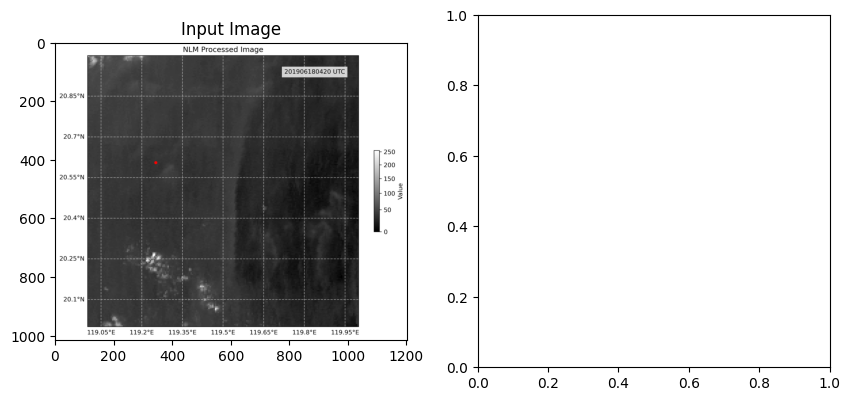

: 

In [10]:
import matplotlib.pyplot as plt

def plot_img_and_mask(img, mask):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))
    
    # 將圖像從 GPU 移到 CPU，並轉換為 NumPy 數組
    img_np = img.squeeze().cpu().permute(1, 2, 0).numpy()
    
    ax1.imshow(img_np)
    ax1.set_title('Input Image')
    ax2.imshow(mask, interpolation='nearest')
    ax2.set_title('Predicted Mask')
    plt.show()

# 對於二分類問題
# 後處理預測結果
if model.n_classes == 1:
    mask_pred = (mask_pred > 0.5).astype(np.uint8)
else:
    mask_pred = np.argmax(mask_pred, axis=0)

plot_img_and_mask(image, mask_pred)